# 🔄 **Validación Cruzada (Cross-Validation)**

**Definición:**  
Es una técnica que **divide varias veces** los datos en entrenamiento y prueba para obtener una **estimación más confiable** del rendimiento de un modelo.

**Problema que resuelve:**  
El clásico *train-test split* (70-30%) **depende mucho** de una división aleatoria específica. Si tienes "mala suerte" con esa división, tu evaluación será incorrecta.

**Solución:**  
Dividir los datos en **k partes (folds)** iguales y hacer **k experimentos**:
- En cada experimento, usar **k-1 partes para entrenar** y **1 parte para probar**
- Rotar la parte de prueba hasta que todas hayan sido usadas
- **Promediar** los resultados de los k experimentos

**Resultado:**  
Una **estimación más estable y confiable** de cómo funcionará tu modelo con datos nuevos, sin depender de una sola división aleatoria.

**Ventaja principal:**  
✅ **Usa todos los datos** para entrenamiento y validación (en diferentes momentos)  
✅ **Reduce el riesgo** de evaluar con una "mala" división aleatoria  
✅ **Especialmente útil** cuando tienes pocos datos

###🔁 ¿Dónde entra el cross-validation?

La validación cruzada (cross-validation) se puede usar tanto para evaluar el rendimiento general de un modelo (estimando sus parámetros) como para ajustar sus hiperparámetros.

Cuando probamos distintas combinaciones de hiperparámetros, no debemos fiarnos solo de una partición del dataset (train/test), ya que puede dar lugar a resultados poco representativos.

📌 Aquí entra la validación cruzada (cross-validation):
Dividimos los datos en k partes (por ejemplo, 5) y entrenamos el modelo 5 veces, cambiando en cada una cuál parte se usa para validar. Así obtenemos una media del rendimiento, más fiable.
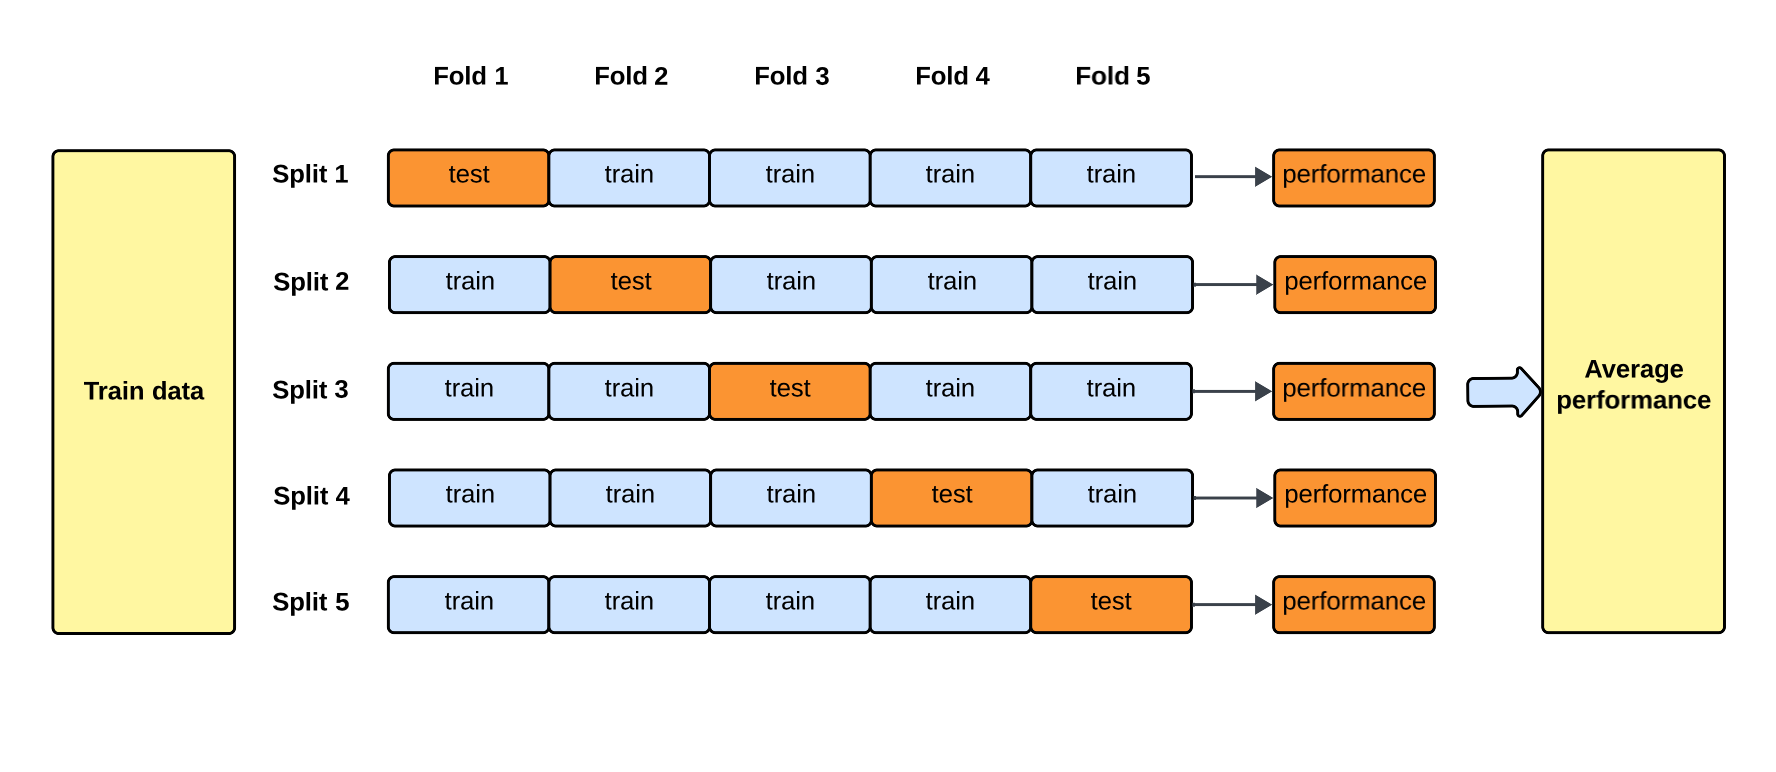

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. CARGAR DATOS REALES
print("=== DATOS REALES: CALIFORNIA HOUSING ===")
housing = fetch_california_housing()
X = housing.data
y = housing.target

print(f"Total muestras: {len(X)}")
print(f"Características: {X.shape[1]}")
print("\nDescripción de características:")
for i, feature_name in enumerate(housing.feature_names):
    print(f"  {i+1}. {feature_name}")

# 2. PROBLEMA DEL TRAIN-TEST SPLIT SIMPLE
print("\n=== PROBLEMA DEL TRAIN-TEST SPLIT SIMPLE ===")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {len(X_train)} muestras ({len(X_train)/len(X)*100:.0f}%)")
print(f"Test: {len(X_test)} muestras ({len(X_test)/len(X)*100:.0f}%)")

model = LinearRegression()
model.fit(X_train, y_train)

# Métricas en test simple
y_pred_simple = model.predict(X_test)
mse_simple = mean_squared_error(y_test, y_pred_simple)
r2_simple = r2_score(y_test, y_pred_simple)

print(f"\n📊 Métricas en test simple:")
print(f"  • MSE: {mse_simple:.4f}")
print(f"  • R²: {r2_simple:.4f}")

print("\n⚠️ PROBLEMA: Estas métricas dependen MUCHO de cómo dividimos los datos.")
print("Si cambio random_state, los valores pueden variar mucho!")

# 3. SOLUCIÓN: CROSS-VALIDATION (K-Fold básico)
print("\n" + "="*60)
print("=== SOLUCIÓN: CROSS-VALIDATION K-FOLD ===")
print("="*60)

# Crear 5 folds (particiones)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_mse_scores = []
fold_r2_scores = []
fold_details = []

print(f"\nDividiendo los {len(X)} datos en 5 folds:")
for fold_num, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Entrenar modelo en este fold
    model.fit(X_train_fold, y_train_fold)

    # Evaluar en el fold de validación
    y_pred_fold = model.predict(X_val_fold)
    mse_fold = mean_squared_error(y_val_fold, y_pred_fold)
    r2_fold = r2_score(y_val_fold, y_pred_fold)

    fold_mse_scores.append(mse_fold)
    fold_r2_scores.append(r2_fold)
    fold_details.append({
        'fold': fold_num,
        'train_size': len(X_train_fold),
        'val_size': len(X_val_fold),
        'mse': mse_fold,
        'r2': r2_fold
    })

    print(f"\nFold {fold_num}:")
    print(f"  - Entrenamiento: {len(X_train_fold)} muestras")
    print(f"  - Validación: {len(X_val_fold)} muestras")
    print(f"  - MSE: {mse_fold:.4f}")
    print(f"  - R²: {r2_fold:.4f}")

# 4. RESULTADOS FINALES
print("\n" + "="*60)
print("=== RESULTADOS FINALES ===")
print("="*60)

print("\n📈 MÉTRICAS POR FOLD:")
print("-" * 40)
print(f"{'Fold':^6} | {'MSE':^10} | {'R²':^10}")
print("-" * 40)
for detail in fold_details:
    print(f"{detail['fold']:^6} | {detail['mse']:^10.4f} | {detail['r2']:^10.4f}")
print("-" * 40)

print(f"\n📊 RESUMEN ESTADÍSTICO:")
print("MSE - Error Cuadrático Medio:")
print(f"  • Promedio: {np.mean(fold_mse_scores):.4f}")
print(f"  • Desviación estándar: {np.std(fold_mse_scores):.4f}")
print(f"  • Rango: [{np.min(fold_mse_scores):.4f}, {np.max(fold_mse_scores):.4f}]")

print("\nR² - Coeficiente de Determinación:")
print(f"  • Promedio: {np.mean(fold_r2_scores):.4f}")
print(f"  • Desviación estándar: {np.std(fold_r2_scores):.4f}")
print(f"  • Rango: [{np.min(fold_r2_scores):.4f}, {np.max(fold_r2_scores):.4f}]")

# 5. COMPARACIÓN FINAL
print("\n" + "="*60)
print("=== COMPARACIÓN FINAL ===")
print("="*60)

print(f"\n📊 TRAIN-TEST SPLIT SIMPLE (una sola división):")
print(f"  • MSE: {mse_simple:.4f}")
print(f"  • R²: {r2_simple:.4f}")

print(f"\n📊 CROSS-VALIDATION (promedio de 5 folds):")
print(f"  • MSE: {np.mean(fold_mse_scores):.4f} ± {np.std(fold_mse_scores):.4f}")
print(f"  • R²: {np.mean(fold_r2_scores):.4f} ± {np.std(fold_r2_scores):.4f}")

print(f"\n📈 DIFERENCIAS:")
print(f"  • MSE: {abs(mse_simple - np.mean(fold_mse_scores)):.4f}")
print(f"  • R²: {abs(r2_simple - np.mean(fold_r2_scores)):.4f}")

# 6. INTERPRETACIÓN
print("\n" + "="*60)
print("=== INTERPRETACIÓN ===")
print("="*60)

print("""
¿QUÉ SIGNIFICAN LAS MÉTRICAS?

MSE (Error Cuadrático Medio):
• Mide el error promedio al cuadrado
• Menor valor = mejor modelo
• Sensible a outliers (errores grandes pesan más)

R² (Coeficiente de Determinación):
• Mide cuánta variabilidad explica el modelo
• Rango: 0 a 1 (idealmente cerca de 1)
• 0 = modelo no explica nada
• 1 = modelo explica toda la variabilidad
• Puede ser negativo si el modelo es peor que usar la media

¿POR QUÉ USAR CROSS-VALIDATION?

1. ESTIMACIÓN MÁS CONFIABLE:
   • Train-test simple: Depende de una división aleatoria
   • Cross-validation: Promedia múltiples divisiones

2. VISIÓN DE LA VARIABILIDAD:
   • Podemos ver cuánto varía el rendimiento (desviación estándar)
   • Si los folds tienen métricas muy diferentes → modelo inestable

3. MEJOR GENERALIZACIÓN:
   • Entrena con diferentes subconjuntos de datos
   • Valida con diferentes subconjuntos
   • Estimación más robusta del rendimiento real

EJEMPLO PRÁCTICO:
Si R² en cross-validation es 0.6 ± 0.05, significa:
• En promedio, el modelo explica 60% de la variabilidad
• Pero puede explicar entre 55% y 65% dependiendo de los datos
• Esto es más informativo que decir "explica 62%" (de una sola división)
""")

=== DATOS REALES: CALIFORNIA HOUSING ===
Total muestras: 20640
Características: 8

Descripción de características:
  1. MedInc
  2. HouseAge
  3. AveRooms
  4. AveBedrms
  5. Population
  6. AveOccup
  7. Latitude
  8. Longitude

=== PROBLEMA DEL TRAIN-TEST SPLIT SIMPLE ===
Train: 16512 muestras (80%)
Test: 4128 muestras (20%)

📊 Métricas en test simple:
  • MSE: 0.5559
  • R²: 0.5758

⚠️ PROBLEMA: Estas métricas dependen MUCHO de cómo dividimos los datos.
Si cambio random_state, los valores pueden variar mucho!

=== SOLUCIÓN: CROSS-VALIDATION K-FOLD ===

Dividiendo los 20640 datos en 5 folds:

Fold 1:
  - Entrenamiento: 16512 muestras
  - Validación: 4128 muestras
  - MSE: 0.5559
  - R²: 0.5758

Fold 2:
  - Entrenamiento: 16512 muestras
  - Validación: 4128 muestras
  - MSE: 0.5277
  - R²: 0.6137

Fold 3:
  - Entrenamiento: 16512 muestras
  - Validación: 4128 muestras
  - MSE: 0.5093
  - R²: 0.6086

Fold 4:
  - Entrenamiento: 16512 muestras
  - Validación: 4128 muestras
  - MSE: 0.504

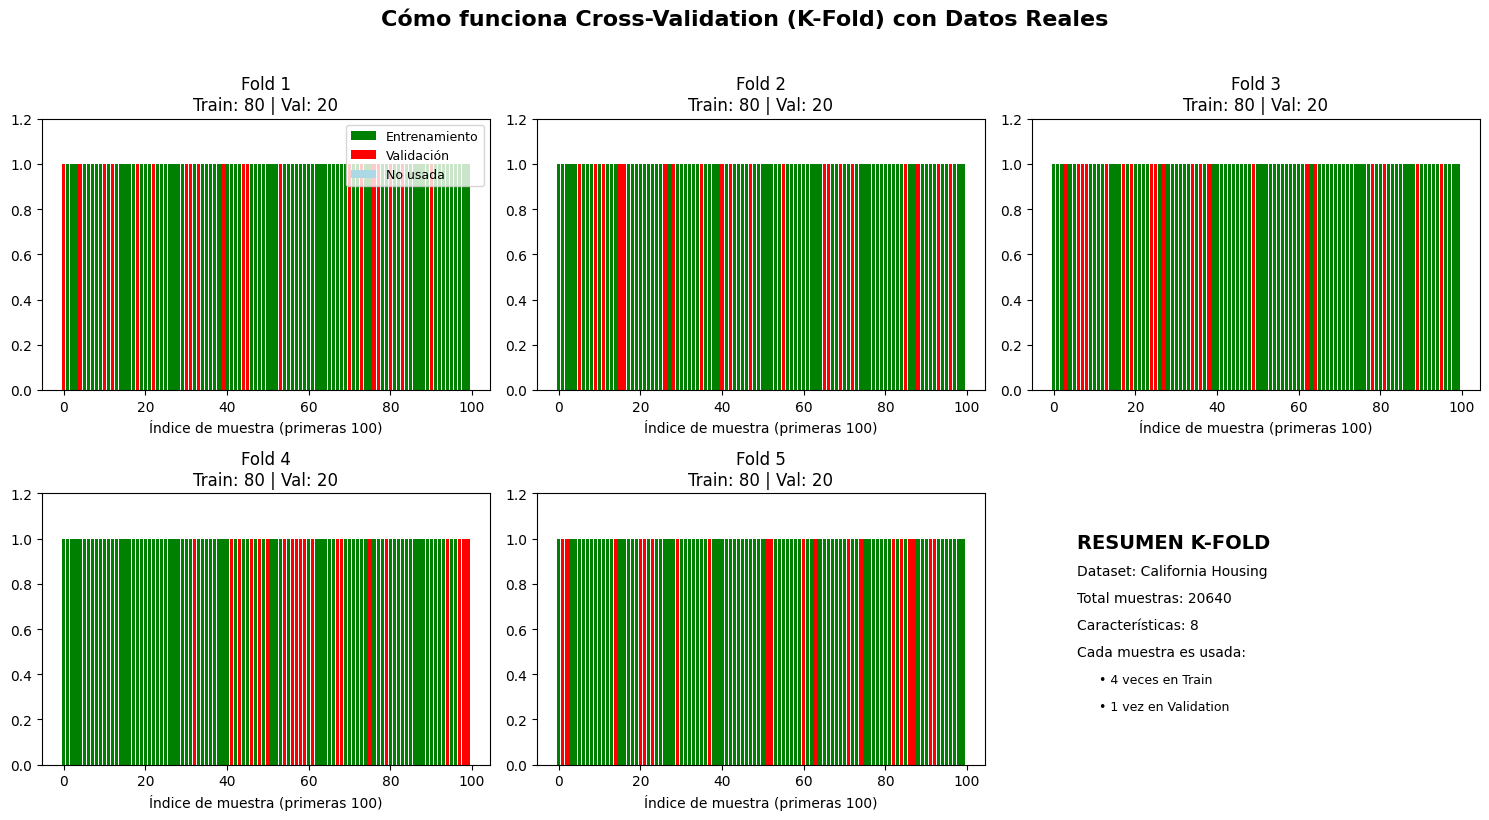

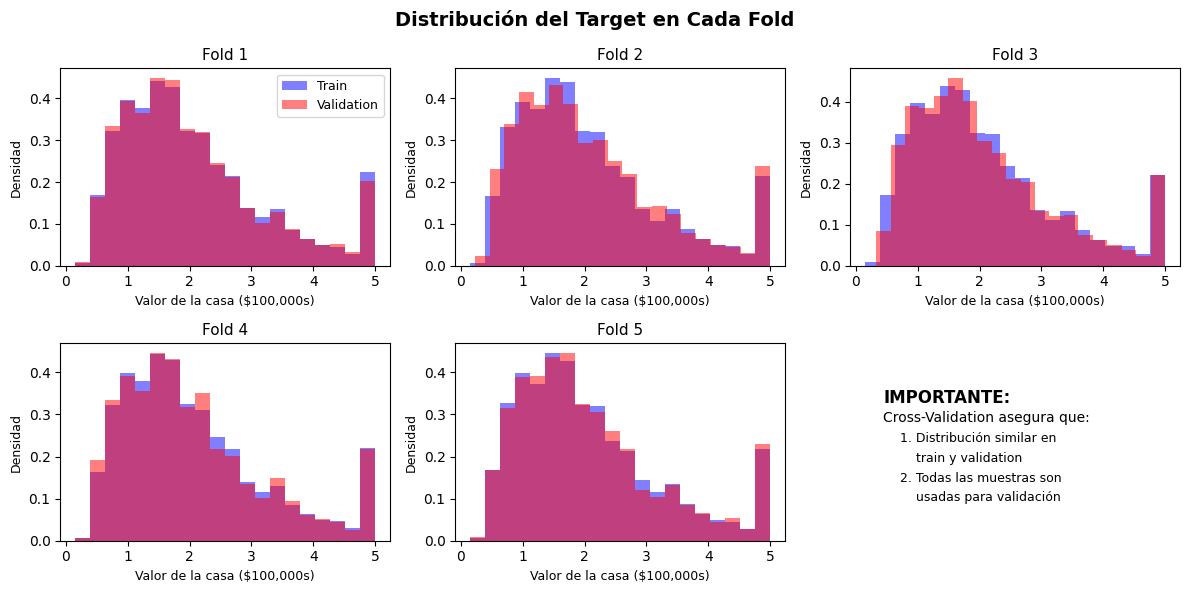

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold

# Cargar datos
housing = fetch_california_housing()
X = housing.data
y = housing.target

# Crear folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Para visualización simple (solo mostramos primeras 100 muestras para claridad)
data_indices = np.arange(100)  # Solo primeras 100 para visualización más clara

# Crear gráfico
plt.figure(figsize=(15, 8))

for fold_num, (train_idx, val_idx) in enumerate(kf.split(data_indices), 1):
    # Filtrar solo las primeras 100 muestras para visualización
    train_idx_filtered = [i for i in train_idx if i < 100]
    val_idx_filtered = [i for i in val_idx if i < 100]

    plt.subplot(2, 3, fold_num)

    # Crear array de colores
    colors = ['lightblue'] * 100
    for idx in train_idx_filtered:
        colors[idx] = 'green'  # Train
    for idx in val_idx_filtered:
        colors[idx] = 'red'    # Validation

    # Crear barras con etiquetas
    bars = plt.bar(range(100), [1]*100, color=colors)
    plt.title(f'Fold {fold_num}\nTrain: {len(train_idx_filtered)} | Val: {len(val_idx_filtered)}', fontsize=12)
    plt.xlabel('Índice de muestra (primeras 100)', fontsize=10)
    plt.ylabel('')
    plt.ylim(0, 1.2)

    # Añadir leyenda en el primer gráfico
    if fold_num == 1:
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='green', label='Entrenamiento'),
            Patch(facecolor='red', label='Validación'),
            Patch(facecolor='lightblue', label='No usada')
        ]
        plt.legend(handles=legend_elements, loc='upper right', fontsize=9)

# Panel de resumen
plt.subplot(2, 3, 6)
plt.text(0.1, 0.8, "RESUMEN K-FOLD", fontsize=14, fontweight='bold')
plt.text(0.1, 0.7, f"Dataset: California Housing", fontsize=10)
plt.text(0.1, 0.6, f"Total muestras: {len(X)}", fontsize=10)
plt.text(0.1, 0.5, f"Características: {X.shape[1]}", fontsize=10)
plt.text(0.1, 0.4, "Cada muestra es usada:", fontsize=10)
plt.text(0.15, 0.3, "• 4 veces en Train", fontsize=9)
plt.text(0.15, 0.2, "• 1 vez en Validation", fontsize=9)
plt.axis('off')

plt.suptitle('Cómo funciona Cross-Validation (K-Fold) ',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Gráfico adicional: Distribución del target en cada fold
plt.figure(figsize=(12, 6))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_num, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    plt.subplot(2, 3, fold_num)

    # Histograma del target en train y val
    plt.hist(y[train_idx], alpha=0.5, label='Train', bins=20, color='blue', density=True)
    plt.hist(y[val_idx], alpha=0.5, label='Validation', bins=20, color='red', density=True)

    plt.title(f'Fold {fold_num}', fontsize=11)
    plt.xlabel('Valor de la casa ($100,000s)', fontsize=9)
    plt.ylabel('Densidad', fontsize=9)

    if fold_num == 1:
        plt.legend(fontsize=9)

plt.subplot(2, 3, 6)
plt.text(0.1, 0.7, "IMPORTANTE:", fontsize=12, fontweight='bold')
plt.text(0.1, 0.6, "Cross-Validation asegura que:", fontsize=10)
plt.text(0.15, 0.5, "1. Distribución similar en", fontsize=9)
plt.text(0.2, 0.4, "train y validation", fontsize=9)
plt.text(0.15, 0.3, "2. Todas las muestras son", fontsize=9)
plt.text(0.2, 0.2, "usadas para validación", fontsize=9)
plt.axis('off')

plt.suptitle('Distribución del Target en Cada Fold', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Ajuste de HyperParametros

###🎛️ ¿Qué es el ajuste de hiperparámetros?

El ajuste de hiperparámetros es el proceso de buscar la mejor combinación posible de estos hiperparámetros para que el modelo funcione bien.

Para ello, se prueba el modelo con diferentes combinaciones y se evalúa su rendimiento.

### 🧪 Tipos de búsqueda de hiperparámetros

| Tipo                         | Descripción                                                       | Ventajas                                       | Inconvenientes                |
|------------------------------|--------------------------------------------------------------------|------------------------------------------------|-------------------------------|
| **Grid Search**              | Prueba todas las combinaciones posibles de hiperparámetros         | Exhaustivo                                     | Muy lento si hay muchos       |
| **Random Search**            | Prueba combinaciones aleatorias dentro de un rango definido        | Más rápido, puede encontrar buenos resultados  | No garantiza el mejor         |
| **Bayesian Search, Optuna, etc.** | Usan técnicas estadísticas para decidir qué probar después         | Muy eficientes                                 | Más complejos                 |



### ✏️ Ejemplo con GridSearchCV y Datos Ficticios

In [6]:
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Crear un dataset ficticio
X, y = make_regression(n_samples=200, n_features=5, noise=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo base
model = Ridge()

# Hiperparámetros a ajustar (solo alpha en este caso)
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]

}

# Búsqueda con validación cruzada
scoring = {
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error'
}

grid_search = GridSearchCV(model,param_grid,cv=5,scoring=scoring,refit='R2')
grid_search.fit(X_train, y_train)

print("Mejor valor de alpha:", grid_search.best_params_)
print("Error cuadrático medio (MSE) en test:", mean_squared_error(y_test, grid_search.predict(X_test)))
print("R2 en test:", grid_search.score(X_test, y_test))


Mejor valor de alpha: {'alpha': 0.01}
Error cuadrático medio (MSE) en test: 85.04240929865
R2 en test: 0.9901964247165793


📌 Nota:

scoring=**'neg_mean_squared_error'** se usa porque sklearn transforma las métricas de pérdida en “puntajes”, y los convierte en negativos para que mayores = mejores.

### ✏️ Ejemplo con GridSearchCV y Fetch california houses data

In [9]:
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Cargar el dataset de California Housing
california = fetch_california_housing()
X, y = california.data, california.target

# Ver información del dataset
print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)
print("\nNombres de las características:", california.feature_names)
print("\nDescripción del dataset:")
print(california.DESCR[:500] + "...")

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalar los datos (importante para Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo base
model = Ridge()

# Hiperparámetros a ajustar
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

# Configuración de métricas para validación cruzada
scoring = {
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error'
}

# Búsqueda con validación cruzada
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring=scoring,
    refit='R2',
    return_train_score=True,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

grid_search.fit(X_train_scaled, y_train)

# Resultados
print("\n" + "="*60)
print("RESULTADOS DE LA BÚSQUEDA DE HIPERPARÁMETROS")
print("="*60)

print(f"\nMejor valor de alpha: {grid_search.best_params_}")
print(f"Mejor puntuación R2 en validación cruzada: {grid_search.best_score_:.4f}")

# Evaluar en conjunto de test
y_pred = grid_search.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
r2_test = grid_search.score(X_test_scaled, y_test)

print(f"\nMÉTRICAS EN CONJUNTO DE TEST:")
print(f"MSE (Error Cuadrático Medio): {mse_test:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse_test:.4f}")
print(f"R² (Coeficiente de determinación): {r2_test:.4f}")

# Resultados detallados de la búsqueda
print("\n" + "="*60)
print("RESULTADOS DETALLADOS POR VALOR DE ALPHA")
print("="*60)

# Crear DataFrame con resultados
results_df = pd.DataFrame(grid_search.cv_results_)

# Mostrar solo las columnas más relevantes
display_cols = ['param_alpha', 'mean_test_R2', 'std_test_R2',
                'mean_test_RMSE', 'mean_test_MAE']

print(results_df[display_cols].sort_values('mean_test_R2', ascending=False).to_string(index=False))

# Comparar con modelo sin regularización (alpha=0 es equivalente a OLS)
print("\n" + "="*60)
print("COMPARACIÓN CON MODELO SIN REGULARIZACIÓN")
print("="*60)

# Modelo Ridge con alpha muy pequeño (similar a OLS pero estable)
model_ols_like = Ridge(alpha=0.001)
model_ols_like.fit(X_train_scaled, y_train)
r2_ols = model_ols_like.score(X_test_scaled, y_test)

print(f"R² en test con alpha=0.001 (similar a OLS): {r2_ols:.4f}")
print(f"R² en test con mejor Ridge (alpha={grid_search.best_params_['alpha']}): {r2_test:.4f}")
print(f"Diferencia: {r2_test - r2_ols:.4f}")

# Coeficientes del mejor modelo
print("\n" + "="*60)
print("COEFICIENTES DEL MEJOR MODELO RIDGE")
print("="*60)

best_model = grid_search.best_estimator_
coefficients = pd.DataFrame({
    'Característica': california.feature_names,
    'Coeficiente': best_model.coef_
})
print(coefficients.sort_values('Coeficiente', key=abs, ascending=False).to_string(index=False))

Dimensiones de X: (20640, 8)
Dimensiones de y: (20640,)

Nombres de las características: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Descripción del dataset:
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group popu...

RESULTADOS DE LA BÚSQUEDA DE HIPERPARÁMETROS

Mejor valor de alpha: {'alpha': 0.001}
Mejor puntuación R2 en validación cruzada: 0.6115

MÉTRICAS EN CONJUNTO DE TEST:
MSE (Error Cuadrático Medio): 0.5559
RMSE (Raíz del Error Cuadrático Medio): 0.7456
R² (Coeficiente de determinació

###🔄 Ejemplo con RandomizedSearchCV con datos ficticios

In [8]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Modelo base
model = Lasso()

# Distribución de hiperparámetros
param_dist = {
    'alpha': loguniform(1e-4, 1e2)
}


scoring = {
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error'
}
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring= scoring, refit='R2', random_state=42)
random_search.fit(X_train, y_train)

print("Mejor alpha (random):", random_search.best_params_)
print("MSE en test:", mean_squared_error(y_test, random_search.predict(X_test)))
print("R2 en test:", random_search.score(X_test, y_test))


Mejor alpha (random): {'alpha': np.float64(0.00022310108018679258)}
MSE en test: 85.05733361169769
R2 en test: 0.9901947042617177


🔢 ¿Por qué usar loguniform(1e-4, 1e2)?
loguniform genera valores aleatorios en escala logarítmica, entre 10⁻⁴ y 10², es decir entre 0.0001 y 100.

📌 Eso es útil porque:

Los valores óptimos de alpha pueden variar mucho (¡pueden ser muy pequeños o muy grandes!).

No tiene sentido probar alpha = 1, 2, 3... 100 (en escala lineal), porque puedes pasarte por alto buenos valores pequeños.

Usar una escala logarítmica permite explorar varios órdenes de magnitud de forma más eficiente.

###🔄 Ejemplo con RandomizedSearchCV con Fetch california houses data

DATASET CALIFORNIA HOUSING - REGRESIÓN CON LASSO
Dimensiones de X: (20640, 8)
Dimensiones de y: (20640,)

Número de características: 8
Nombres: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

EJECUTANDO RANDOMIZED SEARCH CON LASSO...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

RESULTADOS DE RANDOMIZED SEARCH

Mejores parámetros encontrados:
  alpha: 0.0006870101665590031
  selection: random

Mejor puntuación R2 en validación cruzada: 0.6115

MÉTRICAS EN CONJUNTO DE TEST:
R² (Coeficiente de determinación): 0.5765
MSE (Error Cuadrático Medio): 0.5549
RMSE (Raíz del Error Cuadrático Medio): 0.7449
MAE (Error Absoluto Medio): 0.5332

ANÁLISIS DE SELECCIÓN DE CARACTERÍSTICAS
Características seleccionadas (coeficiente ≠ 0): 8/8
Características eliminadas (coeficiente = 0): 0/8

Coeficientes del mejor modelo Lasso:
Característica  Coeficiente  |Coeficiente|  Seleccionada
      Latitude    -0.889289       0.889289          

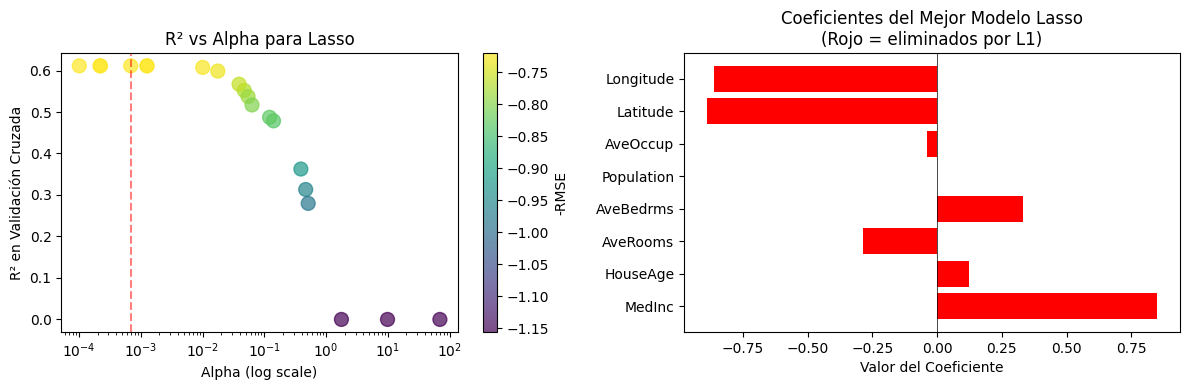


MÉTRICAS ADICIONALES
Error porcentual medio absoluto: 31.94%

Distribución de errores en test:
  Media de errores: 0.0035
  Desviación estándar de errores: 0.7449
  Error mínimo: -9.6727
  Error máximo: 4.1499

Primeras 10 predicciones vs valores reales:
 Valor Real  Predicción  Error  Error %
       0.48        0.72  -0.25    51.74
       0.46        1.76  -1.30   284.69
       5.00        2.70   2.30    46.00
       2.19        2.84  -0.65    29.83
       2.78        2.60   0.18     6.45
       1.59        2.01  -0.43    26.93
       1.98        2.65  -0.66    33.50
       1.58        2.17  -0.59    37.67
       3.40        2.73   0.67    19.73
       4.47        3.92   0.55    12.33


In [10]:
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform, uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar el dataset de California Housing
california = fetch_california_housing()
X, y = california.data, california.target

# Ver información del dataset
print("="*60)
print("DATASET CALIFORNIA HOUSING - REGRESIÓN CON LASSO")
print("="*60)
print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")
print(f"\nNúmero de características: {X.shape[1]}")
print(f"Nombres: {california.feature_names}")

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalar los datos (CRUCIAL para Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo base Lasso
model = Lasso(max_iter=10000, random_state=42)  # Aumentamos iteraciones para convergencia

# Distribución de hiperparámetros más completa
param_dist = {
    'alpha': loguniform(1e-4, 1e2),  # Distribución logarítmica para alpha
    'selection': ['cyclic', 'random'],  # Estrategia de selección de características
}

# Configuración de métricas
scoring = {
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error'
}

# Búsqueda aleatoria con validación cruzada
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=20,  # Número de combinaciones a probar
    cv=5,
    scoring=scoring,
    refit='R2',
    random_state=42,
    n_jobs=-1,
    verbose=1  # Para ver progreso
)

print("\n" + "="*60)
print("EJECUTANDO RANDOMIZED SEARCH CON LASSO...")
print("="*60)

random_search.fit(X_train_scaled, y_train)

# Resultados principales
print("\n" + "="*60)
print("RESULTADOS DE RANDOMIZED SEARCH")
print("="*60)

print(f"\nMejores parámetros encontrados:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor puntuación R2 en validación cruzada: {random_search.best_score_:.4f}")

# Evaluar en conjunto de test
y_pred = random_search.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = random_search.score(X_test_scaled, y_test)

print(f"\nMÉTRICAS EN CONJUNTO DE TEST:")
print(f"R² (Coeficiente de determinación): {r2_test:.4f}")
print(f"MSE (Error Cuadrático Medio): {mse_test:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse_test:.4f}")
print(f"MAE (Error Absoluto Medio): {mae_test:.4f}")

# Análisis de selección de características con Lasso
print("\n" + "="*60)
print("ANÁLISIS DE SELECCIÓN DE CARACTERÍSTICAS")
print("="*60)

best_model = random_search.best_estimator_
coefficients = best_model.coef_
n_selected_features = np.sum(coefficients != 0)
n_zero_coefficients = np.sum(coefficients == 0)

print(f"Características seleccionadas (coeficiente ≠ 0): {n_selected_features}/{X.shape[1]}")
print(f"Características eliminadas (coeficiente = 0): {n_zero_coefficients}/{X.shape[1]}")

# Mostrar coeficientes
coefficients_df = pd.DataFrame({
    'Característica': california.feature_names,
    'Coeficiente': coefficients,
    '|Coeficiente|': np.abs(coefficients),
    'Seleccionada': coefficients != 0
})

print("\nCoeficientes del mejor modelo Lasso:")
print(coefficients_df.sort_values('|Coeficiente|', ascending=False).to_string(index=False))

# Resultados detallados de todas las combinaciones probadas
print("\n" + "="*60)
print("RESULTADOS DETALLADOS DE TODAS LAS COMBINACIONES")
print("="*60)

results_df = pd.DataFrame(random_search.cv_results_)
display_cols = ['param_alpha', 'param_selection',
                'mean_test_R2', 'std_test_R2',
                'mean_test_RMSE', 'mean_test_MAE',
                'rank_test_R2']

print(results_df[display_cols].sort_values('rank_test_R2').head(10).to_string(index=False))

# Comparación con modelo Ridge del ejemplo anterior
print("\n" + "="*60)
print("COMPARACIÓN RÁPIDA CON REGRESIÓN RIDGE")
print("="*60)

# Modelo Ridge simple para comparar
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
ridge_r2 = ridge_model.score(X_test_scaled, y_test)
ridge_coef_nonzero = np.sum(ridge_model.coef_ != 0)

print(f"LASSO (mejor modelo):")
print(f"  - R² en test: {r2_test:.4f}")
print(f"  - Características seleccionadas: {n_selected_features}")
print(f"\nRIDGE (alpha=1.0):")
print(f"  - R² en test: {ridge_r2:.4f}")
print(f"  - Características seleccionadas: {ridge_coef_nonzero} (todas)")

# Visualización de resultados (opcional)
print("\n" + "="*60)
print("VISUALIZACIÓN DE RESULTADOS")
print("="*60)

# 1. Evolución de R2 vs alpha
plt.figure(figsize=(12, 4))

# Gráfico 1: R2 vs alpha
plt.subplot(1, 2, 1)
scatter = plt.scatter(results_df['param_alpha'],
                      results_df['mean_test_R2'],
                      c=results_df['mean_test_RMSE'],
                      cmap='viridis',
                      s=100,
                      alpha=0.7)
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('R² en Validación Cruzada')
plt.title('R² vs Alpha para Lasso')
plt.colorbar(scatter, label='-RMSE')
plt.axvline(random_search.best_params_['alpha'], color='red', linestyle='--', alpha=0.5)

# Gráfico 2: Coeficientes del mejor modelo
plt.subplot(1, 2, 2)
colors = ['red' if c == 0 else 'blue' for c in (coefficients == 0)]
plt.barh(range(len(coefficients)), coefficients, color=colors)
plt.yticks(range(len(coefficients)), california.feature_names)
plt.xlabel('Valor del Coeficiente')
plt.title('Coeficientes del Mejor Modelo Lasso\n(Rojo = eliminados por L1)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

# Métricas adicionales
print("\n" + "="*60)
print("MÉTRICAS ADICIONALES")
print("="*60)

# Error porcentual medio
percentage_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Error porcentual medio absoluto: {percentage_error:.2f}%")

# Distribución de errores
errors = y_test - y_pred
print(f"\nDistribución de errores en test:")
print(f"  Media de errores: {np.mean(errors):.4f}")
print(f"  Desviación estándar de errores: {np.std(errors):.4f}")
print(f"  Error mínimo: {np.min(errors):.4f}")
print(f"  Error máximo: {np.max(errors):.4f}")

# Predicciones vs valores reales (sample)
print(f"\nPrimeras 10 predicciones vs valores reales:")
comparison_df = pd.DataFrame({
    'Valor Real': y_test[:10],
    'Predicción': y_pred[:10],
    'Error': errors[:10],
    'Error %': np.abs(errors[:10] / y_test[:10]) * 100
})
print(comparison_df.round(2).to_string(index=False))